In [ ]:
import torch
from PIL import Image
from torchvision import transforms

# --- 1. CONFIGURATION ---
# Define the device for Apple Silicon (M3)
# if torch.backends.mps.is_available():
#     device = torch.device('mps')
# else:
#     device = torch.device('cpu')
    
device = torch.device('cpu')

print(f"Using device: {device}")

# Define the path to your image
# IMPORTANT: Replace this with the actual path to your image file.
IMAGE_PATH = '/Users/andresmr/Documents/dinov2/images/original.jpg' 

# --- 2. LOAD THE DINOv2 MODEL ---
# Load one of the pretrained DINOv2 models
model = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitl14')
model.to(device)
model.eval() # Set the model to evaluation mode

# --- 3. PREPARE THE IMAGE ---
# DINOv2 requires specific image transformations
transform = transforms.Compose([
    transforms.Resize(256, interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
])

# Load and transform the image
try:
    img = Image.open(IMAGE_PATH).convert('RGB')
    img_tensor = transform(img).unsqueeze(0).to(device) # Add batch dimension and send to device
except FileNotFoundError:
    print(f"Error: Image not found at {IMAGE_PATH}")
    exit()

# --- 4. GET THE EMBEDDING ---
# Pass the image through the model to get the features
with torch.no_grad():
    embedding = model(img_tensor)

# --- 5. DISPLAY THE OUTPUT ---
print("\n--- DINOv2 Embedding ---")
print(f"Shape of the output tensor: {embedding.shape}")
print("This is the feature vector (embedding) for your image.")
# The embedding tensor is large, so we'll print a small slice of it
print(f"Embedding (first 10 values): {embedding[0, :10]}...")

Using device: mps
Downloading: "https://github.com/facebookresearch/dinov2/zipball/main" to /Users/andresmr/.cache/torch/hub/main.zip


/Users/andresmr/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/Users/andresmr/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/Users/andresmr/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


Downloading: "https://dl.fbaipublicfiles.com/dinov2/dinov2_vitl14/dinov2_vitl14_pretrain.pth" to /Users/andresmr/.cache/torch/hub/checkpoints/dinov2_vitl14_pretrain.pth


100.0%



--- DINOv2 Embedding ---
Shape of the output tensor: torch.Size([1, 1024])
This is the feature vector (embedding) for your image.
Embedding (first 10 values): tensor([ 1.3527,  0.8874,  0.0612, -0.5638,  1.6304,  1.5035, -2.1076,  0.5651,
         2.8194, -0.2373], device='mps:0')...


## New code

In [1]:
# ===================================================================
# PARTE 0: IMPORTACIONES Y CONFIGURACIÓN INICIAL
# ===================================================================
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# --- 1. CONFIGURATION ---
# Mismo setup que tu código, usando MPS si está disponible
# if torch.backends.mps.is_available():
#     device = torch.device('mps')
# else:
#     device = torch.device('cpu')
    
device = torch.device('cpu')
print(f"Using device: {device}")

# --- 2. LOAD THE DINOv2 MODEL ---
# Cargamos el modelo DINOv2 (ViT-Large, patch size 14)
# Lo moveremos al device y lo pondremos en modo eval()
# ya que NUNCA lo entrenaremos.
dinov2_model = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitl14')
dinov2_model.to(device)
dinov2_model.eval()
print("DINOv2 model loaded and set to eval() mode.")

# --- 3. PREPARE THE IMAGE TRANSFORM ---
# Mismas transformaciones que usaste
IMG_SIZE = 224
PATCH_SIZE = 14
NUM_CLASSES = 2 # 0 = no navegable, 1 = navegable
DINO_EMBED_DIM = 1024 # Para ViT-Large
BATCH_SIZE = 4 # Puedes ajustar esto

transform = transforms.Compose([
    transforms.Resize(256, interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
])

Using device: cpu


Using cache found in /Users/andresmr/.cache/torch/hub/facebookresearch_dinov2_main
/Users/andresmr/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/Users/andresmr/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/Users/andresmr/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


DINOv2 model loaded and set to eval() mode.


In [2]:
# ===================================================================
# PARTE 1: FUNCIÓN PARA OBTENER FEATURES DE PARCHES (CORREGIDA OTRA VEZ)
# ===================================================================
PATCH_GRID_SIZE = IMG_SIZE // PATCH_SIZE

def get_patch_features(images_tensor):
    """
    Pasa imágenes a través de DINOv2 congelado y extrae las 
    características de los parches del último bloque.
    
    Entrada:
        images_tensor: Tensor de forma [B, 3, 224, 224]
    
    Salida:
        patch_features: Tensor de forma [B, 1024, 16, 16]
    """
    with torch.no_grad():
        features = dinov2_model.get_intermediate_layers(images_tensor, n=1)[0]

    # features ya tiene la forma [B, 256, 1024] (SOLO patch tokens)
    patch_features = features 
    
    # Remodelamos a un formato de "mapa de características" 2D
    # B, H*W, C -> B, C, H, W
    batch_size = patch_features.shape[0]
    
    # --- ESTA ES LA LÍNEA CORREGIDA ---
    # .permute() crea un tensor no contiguo.
    # Añadimos .contiguous() para forzarlo a un nuevo bloque de memoria.
    patch_features = patch_features.permute(0, 2, 1).contiguous() 
    # ---------------------------------

    patch_features = patch_features.reshape(batch_size, DINO_EMBED_DIM, PATCH_GRID_SIZE, PATCH_GRID_SIZE)
    
    return patch_features # Forma: [B, 1024, 16, 16]

# --- Prueba rápida de la función (opcional) ---
print("Definición de 'get_patch_features' actualizada (con .contiguous()).")
dummy_img = torch.randn(1, 3, IMG_SIZE, IMG_SIZE).to(device)
features = get_patch_features(dummy_img)
print(f"Forma de las características de parches: {features.shape}")

Definición de 'get_patch_features' actualizada (con .contiguous()).
Forma de las características de parches: torch.Size([1, 1024, 16, 16])


In [8]:
# ===================================================================
# PARTE 2: DEFINIR EL CABEZAL DE SEGMENTACIÓN MLP
# ===================================================================

class SimpleMLPHead(nn.Module):
    def __init__(self, in_channels, num_classes, hidden_dim=256, dropout=0.1):
        """
        Cabezal MLP ligero usando Convoluciones 1x1.
        
        in_channels: Dimensión de las características de DINOv2 (1024 para ViT-L)
        num_classes: Clases de salida (2 para ti: 'navegable', 'no navegable')
        hidden_dim: Dimensión de la capa oculta
        """
        super().__init__()
        
        self.num_classes = num_classes
        
        # Capa 1: Reduce la dimensión
        self.fc1 = nn.Conv2d(in_channels, hidden_dim, kernel_size=1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        
        # Capa 2: Clasifica a num_classes
        self.fc2 = nn.Conv2d(hidden_dim, num_classes, kernel_size=1)

    def forward(self, x):
        # x tiene forma [B, 1024, 16, 16]
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x) # Forma: [B, 2, 16, 16]
        
        # Re-escalamos la salida de 16x16 al tamaño original de la imagen 224x224
        # 'bilinear' es bueno para la segmentación.
        output = F.interpolate(x, 
                             size=(IMG_SIZE, IMG_SIZE), 
                             mode='bilinear', 
                             align_corners=False)
        
        return output # Forma: [B, 2, 224, 224]

# --- Instanciar el cabezal ---
# 0 = fondo/no navegable, 1 = navegable
NUM_CLASSES = 2 
seg_head = SimpleMLPHead(in_channels=DINO_EMBED_DIM, num_classes=NUM_CLASSES)
seg_head.to(device)

print(f"Cabezal de segmentación creado. Número de clases: {NUM_CLASSES}")

Cabezal de segmentación creado. Número de clases: 2


In [ ]:
#!pip install opencv-python-headless numpy
#!pip install tqdm

  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
Using cached tqdm-4.67.1-py3-none-any.whl (78 kB)


### convert coco segmentation format to right format

In [4]:
import json
import os
import numpy as np
import cv2 # OpenCV
from tqdm import tqdm # Para una barra de progreso

def coco2masks(COCO_JSON_PATH, MASK_OUTPUT_DIR):
    # --- 2. CREAR DIRECTORIO DE SALIDA ---
    os.makedirs(MASK_OUTPUT_DIR, exist_ok=True)
    print(f"Directorio de máscaras creado en: {MASK_OUTPUT_DIR}")

    # --- 3. CARGAR EL ARCHIVO COCO JSON ---
    with open(COCO_JSON_PATH, 'r') as f:
        coco_data = json.load(f)

    # --- 4. PREPARAR DICCIONARIOS PARA BÚSQUEDA RÁPIDA ---
    images_dict = {img['id']: img for img in coco_data['images']}
    annotations_dict = {}
    for ann in coco_data['annotations']:
        img_id = ann['image_id']
        if img_id not in annotations_dict:
            annotations_dict[img_id] = []
        annotations_dict[img_id].append(ann)

    # --- 5. PROCESAR CADA IMAGEN Y CREAR MÁSCARAS (CORREGIDO) ---
    print(f"Procesando {len(images_dict)} imágenes para crear máscaras...")

    for img_id, img_info in tqdm(images_dict.items()):
        
        # Crear una máscara negra (vacía). '0' representará 'non-navigable'.
        height = img_info['height']
        width = img_info['width']
        mask = np.zeros((height, width), dtype=np.uint8)
        
        if img_id in annotations_dict:
            annotations = annotations_dict[img_id]
            
            for ann in annotations:
                
                # --- INICIO DE LA CORRECCIÓN ---
                # Leemos el ID de la categoría de la anotación
                category_id = ann['category_id']
                
                # Basado en tu JSON:
                # ID 1 = 'navigable'
                # ID 2 = 'non-navigable'
                
                # SOLO dibujamos los polígonos si son 'navigable' (ID 1)
                if category_id == 1:
                    color_to_draw = 1
                else:
                    # Si es 'non-navigable' (ID 2) o la supercategoría (ID 0),
                    # no hacemos nada, dejando el píxel como 0.
                    continue
                # --- FIN DE LA CORRECCIÓN ---

                for polygon in ann['segmentation']:
                    poly_points = np.array(polygon, dtype=np.int32).reshape(-1, 2)
                    poly_points = poly_points.reshape((-1, 1, 2))
                    
                    # Dibujar el polígono con el color correcto
                    cv2.fillPoly(mask, [poly_points], color=color_to_draw)
                    
        # Guardar la máscara final (que ahora es 0s y 1s correctos)
        mask_filename = os.path.splitext(img_info['file_name'])[0] + ".png"
        mask_save_path = os.path.join(MASK_OUTPUT_DIR, mask_filename)
        cv2.imwrite(mask_save_path, mask)

    print("¡Procesamiento completado!")
    print(f"Todas las máscaras PNG han sido guardadas en {MASK_OUTPUT_DIR}")

# --- 1. CONFIGURACIÓN ---
# El código para llamar a la función sigue siendo el mismo.
COCO_JSON_PATH = '/Users/andresmr/Documents/dinov2/COCO_dataset/train/_annotations.coco.json'
MASK_OUTPUT_DIR = '/Users/andresmr/Documents/dinov2/COCO_dataset/train/masks'
coco2masks(COCO_JSON_PATH, MASK_OUTPUT_DIR)

COCO_JSON_PATH = '/Users/andresmr/Documents/dinov2/COCO_dataset/valid/_annotations.coco.json'
MASK_OUTPUT_DIR = '/Users/andresmr/Documents/dinov2/COCO_dataset/valid/masks'
coco2masks(COCO_JSON_PATH, MASK_OUTPUT_DIR)

COCO_JSON_PATH = '/Users/andresmr/Documents/dinov2/COCO_dataset/test/_annotations.coco.json'
MASK_OUTPUT_DIR = '/Users/andresmr/Documents/dinov2/COCO_dataset/test/masks'
coco2masks(COCO_JSON_PATH, MASK_OUTPUT_DIR)

Directorio de máscaras creado en: /Users/andresmr/Documents/dinov2/COCO_dataset/train/masks
Procesando 81 imágenes para crear máscaras...


100%|██████████| 81/81 [00:00<00:00, 4198.45it/s]


¡Procesamiento completado!
Todas las máscaras PNG han sido guardadas en /Users/andresmr/Documents/dinov2/COCO_dataset/train/masks
Directorio de máscaras creado en: /Users/andresmr/Documents/dinov2/COCO_dataset/valid/masks
Procesando 8 imágenes para crear máscaras...


100%|██████████| 8/8 [00:00<00:00, 4516.68it/s]


¡Procesamiento completado!
Todas las máscaras PNG han sido guardadas en /Users/andresmr/Documents/dinov2/COCO_dataset/valid/masks
Directorio de máscaras creado en: /Users/andresmr/Documents/dinov2/COCO_dataset/test/masks
Procesando 4 imágenes para crear máscaras...


100%|██████████| 4/4 [00:00<00:00, 3891.72it/s]

¡Procesamiento completado!
Todas las máscaras PNG han sido guardadas en /Users/andresmr/Documents/dinov2/COCO_dataset/test/masks


### verificacion de las mascaras


In [4]:
import cv2
import numpy as np
import os

# --- VERIFICACIÓN ---
# Apunta a la carpeta de máscaras que acabas de crear
MASK_OUTPUT_DIR = '/Users/andresmr/Documents/dinov2/COCO_dataset/train/masks'

# Obtener la primera máscara de la carpeta para analizarla
try:
    first_mask_name = os.listdir(MASK_OUTPUT_DIR)[0]
    mask_path = os.path.join(MASK_OUTPUT_DIR, first_mask_name)

    # Cargar la máscara EN MODO UNCHANGED (sin modificar)
    # Esto es crucial para leer los valores 1, en lugar de 0-255
    mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)

    if mask is not None:
        # Encontrar todos los valores de píxeles únicos en la máscara
        unique_values = np.unique(mask)
        
        print(f"Analizando la máscara: {first_mask_name}")
        print(f"Forma de la máscara: {mask.shape}")
        print(f"Valores únicos encontrados: {unique_values}")

        if np.array_equal(unique_values, [0, 1]):
            print("\n¡ÉXITO! Tu código es 100% correcto.")
            print("Los valores '1' están presentes, solo que no son visibles.")
        elif np.array_equal(unique_values, [0]):
            print("\nERROR: La máscara solo contiene ceros. El polígono no se dibujó.")
        else:
            print(f"\nINFO: Se encontraron valores inesperados: {unique_values}")
            
    else:
        print(f"Error: No se pudo cargar la máscara desde {mask_path}")

except IndexError:
    print(f"Error: No se encontraron máscaras en el directorio {MASK_OUTPUT_DIR}")

Analizando la máscara: Screenshot-from-2024-04-04-12-25-30_png.rf.dca214e0f21f7d91b9d57e89109625c3.png
Forma de la máscara: (224, 224)
Valores únicos encontrados: [0 1]

¡ÉXITO! Tu código es 100% correcto.
Los valores '1' están presentes, solo que no son visibles.


Dimensiones de la máscara: (224, 224)
Valores únicos en la máscara visual: [  0 255]


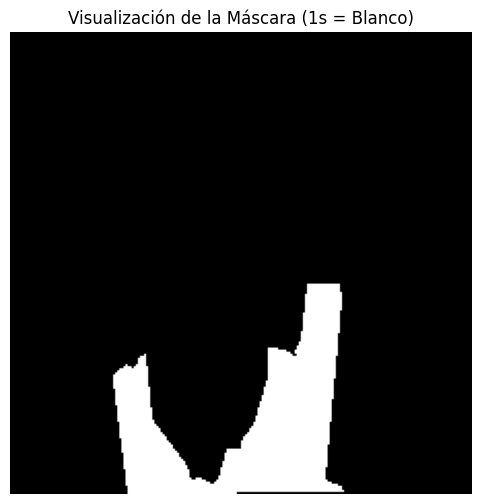

In [5]:
import matplotlib.pyplot as plt
import numpy as np

binary_mask = mask
# ------------------------------------------


# 1. Convertir la máscara para visualización
# Multiplicamos por 255. Los 0s siguen siendo 0, los 1s se convierten en 255.
# .astype(np.uint8) asegura que es un formato de imagen (entero de 0-255).
visual_mask = (binary_mask * 255).astype(np.uint8)

# 2. Graficar la máscara
print(f"Dimensiones de la máscara: {visual_mask.shape}")
print(f"Valores únicos en la máscara visual: {np.unique(visual_mask)}")

plt.figure(figsize=(6, 6))

# Usamos cmap='gray' para mostrarla en blanco y negro (escala de grises)
# vmin y vmax fuerzan el rango de color para que 0 sea negro y 255 blanco
plt.imshow(visual_mask, cmap='gray', vmin=0, vmax=255)

plt.title("Visualización de la Máscara (1s = Blanco)")
plt.axis('off') # Opcional: para ocultar los ejes X e Y
plt.show()

In [ ]:
#!pip install albumentations opencv-python-headless

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 7.1 MB/s  0:00:00 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.4/22.4 MB 5.2 MB/s  0:00:04 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10/10 [albumentations]m [pydantic]


## Part 3

In [3]:
# ===================================================================
# PARTE 3: CARGAR DATOS REALES DE ROBOFLOW (CON AUMENTACIÓN)
# ===================================================================
import os
import numpy as np
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset, DataLoader
from PIL import Image



In [5]:
# --- 1. Definir Transformaciones de Aumentación (CORREGIDO) ---
# Con solo 50 imágenes, la aumentación es CRÍTICA.
# Usamos Albumentations porque aplica las mismas transformaciones 
# (ej. volteo, recorte) a la imagen Y a la máscara.

# Estas son las transformaciones que usará DINOv2
DINO_MEANS = (0.485, 0.456, 0.406)
DINO_STDS = (0.229, 0.224, 0.225)

# OJO: IMG_SIZE = 224 (definido en la Parte 0)
train_transform = A.Compose([
    # Recorta aleatoriamente una región de 224x224 de la imagen.
    # Esto es mucho mejor que un simple CenterCrop para la aumentación.
    
    # --- ESTA ES LA LÍNEA CORREGIDA ---
    # Las nuevas versiones de Albumentations usan 'size' en lugar de 'height' y 'width'
    A.RandomResizedCrop(size=(IMG_SIZE, IMG_SIZE), scale=(0.5, 1.0), p=1.0),
    # ---------------------------------
    
    # Volteo horizontal (50% de probabilidad)
    A.HorizontalFlip(p=0.5),
    
    # Aumentaciones de color (solo se aplican a la imagen, no a la máscara)
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1, p=0.8),
    
    # Normalización de DINOv2
    A.Normalize(mean=DINO_MEANS, std=DINO_STDS),
    
    # Convierte a Tensor de PyTorch
    ToTensorV2()
])


# --- 2. Definir el Dataset Personalizado ---

class RoboflowSegDataset(Dataset):
    def __init__(self, root_dir, transform=None):
            self.root_dir = root_dir
            self.transform = transform
            self.img_dir = os.path.join(root_dir, "images")
            self.mask_dir = os.path.join(root_dir, "masks")
            
            # --- ESTAS SON LAS LÍNEAS CORREGIDAS ---
            # Filtramos la lista para incluir solo los archivos de imagen/máscara
            # Esto ignora archivos ocultos como .DS_Store
            
            # Obtenemos todas las imágenes (asumiendo .jpg, .jpeg, o .png)
            self.images = sorted(
                [f for f in os.listdir(self.img_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]
            )
            
            # Obtenemos todas las máscaras (asumiendo .png de nuestro script)
            self.masks = sorted(
                [f for f in os.listdir(self.mask_dir) if f.endswith('.png')]
            )
            # ----------------------------------------

            # --- Depuración (Opcional pero recomendado) ---
            print(f"Archivos de imagen encontrados: {len(self.images)}")
            print(f"Archivos de máscara encontrados: {len(self.masks)}")
            # -------------------------------------------

            # Verificación rápida para asegurar que las imágenes y máscaras coincidan
            assert len(self.images) == len(self.masks), "Número de imágenes y máscaras no coincide"
            print(f"Dataset cargado. Encontradas {len(self.images)} muestras.")

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # Construir rutas de archivos
        img_path = os.path.join(self.img_dir, self.images[idx])
        
        # Asumimos que la máscara tiene el mismo nombre base pero extensión .png
        mask_name = os.path.splitext(self.images[idx])[0] + ".png"
        mask_path = os.path.join(self.mask_dir, mask_name)

        # Cargar imagen y máscara
        # Albumentations funciona con arrays de NumPy
        image = np.array(Image.open(img_path).convert("RGB"))
        mask = np.array(Image.open(mask_path)) # No convertir, es una máscara de 1 canal

        if self.transform:
            # Aplicar aumentaciones
            augmented = self.transform(image=image, mask=mask)
            image_tensor = augmented['image']
            mask_tensor = augmented['mask']
        
        # Convertir la máscara a tipo Long (requerido por CrossEntropyLoss)
        # y asegurarnos de que no tenga una dimensión de canal
        mask_tensor = mask_tensor.squeeze().long()
        
        return image_tensor, mask_tensor

# --- 3. Crear el DataLoader ---

# !! IMPORTANTE !!
# Cambia esta ruta a la carpeta 'train' que descargaste de Roboflow
DATA_ROOT_DIR = '/Users/andresmr/Documents/dinov2/COCO_dataset/train' 

# Verificar si la ruta existe antes de crear el dataset
if not os.path.isdir(DATA_ROOT_DIR) or not os.path.isdir(os.path.join(DATA_ROOT_DIR, "images")):
    print("="*50)
    print(f"ERROR: La ruta '{DATA_ROOT_DIR}' no existe o no contiene la carpeta 'images'.")
    print("Por favor, actualiza la variable DATA_ROOT_DIR con la ruta correcta.")
    print("El resto del código usará un DataLoader FALSO.")
    print("="*50)
    # Crear un dataloader falso para que el resto del notebook no falle
    dummy_images = torch.randn(50, 3, IMG_SIZE, IMG_SIZE)
    dummy_masks = torch.randint(0, NUM_CLASSES, (50, IMG_SIZE, IMG_SIZE), dtype=torch.long)
    dataset = TensorDataset(dummy_images, dummy_masks)
else:
    # Crear el dataset real
    dataset = RoboflowSegDataset(root_dir=DATA_ROOT_DIR, transform=train_transform)

# Crear el DataLoader
BATCH_SIZE = 4 # Puedes ajustar esto según la VRAM de tu MPS
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)

# Imprimir formas para verificar
if dataset:
    try:
        img_batch, mask_batch = next(iter(dataloader))
        print(f"DataLoader real creado.")
        print(f"Forma de un lote de imágenes: {img_batch.shape}")  # Debería ser [B, 3, 224, 224]
        print(f"Forma de un lote de máscaras: {mask_batch.shape}") # Debería ser [B, 224, 224]
        print(f"Tipo de dato de las máscaras: {mask_batch.dtype}")   # Debería ser torch.int64 (Long)
    except StopIteration:
        print("ERROR: El DataLoader está vacío. ¿La carpeta de datos es correcta y no está vacía?")

Archivos de imagen encontrados: 81
Archivos de máscara encontrados: 81
Dataset cargado. Encontradas 81 muestras.
DataLoader real creado.
Forma de un lote de imágenes: torch.Size([4, 3, 224, 224])
Forma de un lote de máscaras: torch.Size([4, 224, 224])
Tipo de dato de las máscaras: torch.int64


In [8]:
# ===================================================================
# PARTE 3.5: CREAR EL DATALOADER DE VALIDACIÓN
# ===================================================================

# --- 1. Definir Transformaciones de VALIDACIÓN ---
# NO usamos aumentación aquí, solo el preprocesamiento estándar de DINOv2:
# Redimensionar a 256, recortar al centro a 224, normalizar.
val_transform = A.Compose([
    # Redimensiona la imagen a 256x256
    A.Resize(height=256, width=256),
    # Recorta el centro a 224x224
    A.CenterCrop(height=IMG_SIZE, width=IMG_SIZE),
    # Normalización de DINOv2
    A.Normalize(mean=DINO_MEANS, std=DINO_STDS),
    # Convierte a Tensor de PyTorch
    ToTensorV2()
])

# --- 2. Crear el Dataset y DataLoader de Validación ---

# !! IMPORTANTE !!
# Cambia esta ruta a la carpeta 'valid' que descargaste de Roboflow
VALID_DATA_ROOT_DIR = '/Users/andresmr/Documents/dinov2/COCO_dataset/valid' 

validation_dataset = None
validation_dataloader = None

# Verificar si la ruta existe
if not os.path.isdir(VALID_DATA_ROOT_DIR) or not os.path.isdir(os.path.join(VALID_DATA_ROOT_DIR, "images")):
    print("="*50)
    print(f"ADVERTENCIA: La ruta de validación '{VALID_DATA_ROOT_DIR}' no existe.")
    print("El bucle de entrenamiento continuará sin validación.")
    print("="*50)
else:
    # Crear el dataset real de validación
    validation_dataset = RoboflowSegDataset(
        root_dir=VALID_DATA_ROOT_DIR, 
        transform=val_transform  # <-- Usando las transformaciones de validación
    )
    
    # Crear el DataLoader de validación
    # shuffle=False es importante para la validación/testeo
    validation_dataloader = DataLoader(
        validation_dataset, 
        batch_size=BATCH_SIZE, 
        shuffle=False, 
        num_workers=0
    )
    
    print(f"DataLoader de validación creado. Encontradas {len(validation_dataset)} muestras.")

Archivos de imagen encontrados: 8
Archivos de máscara encontrados: 8
Dataset cargado. Encontradas 8 muestras.
DataLoader de validación creado. Encontradas 8 muestras.


## Entrenamiento


In [9]:
# ===================================================================
# PARTE 4: BUCLE DE ENTRENAMIENTO (CON VALIDACIÓN)
# ===================================================================
import torch.optim as optim
from tqdm import tqdm # Para una bonita barra de progreso

#device = 'cpu'
# --- 1. Configuración de entrenamiento ---
NUM_EPOCHS = 50 
LEARNING_RATE = 1e-3 # 0.001

optimizer = optim.Adam(seg_head.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

print("Iniciando entrenamiento...")
print(f"Entrenando solo el 'seg_head' durante {NUM_EPOCHS} épocas.")

# --- 2. Bucle de Entrenamiento y Validación ---

# Guardaremos el mejor modelo basado en la pérdida de VALIDACIÓN
best_val_loss = float('inf') 

for epoch in range(NUM_EPOCHS):
    
    # --- FASE DE ENTRENAMIENTO ---
    seg_head.train()       # Poner el cabezal en modo entrenamiento (activa dropout)
    dinov2_model.eval()    # MANTENER DINOv2 en modo evaluación (congelado)
    
    total_train_loss = 0
    
    # Usamos tqdm para ver el progreso del lote de entrenamiento
    train_loader_tqdm = tqdm(dataloader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Train]")
    
    for images, masks in train_loader_tqdm:
        images = images.to(device)
        masks = masks.to(device) 
        
        patch_features = get_patch_features(images) 
        logits = seg_head(patch_features) 
        loss = criterion(logits, masks)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_train_loss += loss.item()
        train_loader_tqdm.set_postfix(train_loss=loss.item())
    
    avg_train_loss = total_train_loss / len(dataloader)

    # --- FASE DE VALIDACIÓN ---
    # Solo si creamos un dataloader de validación
    if validation_dataloader:
        seg_head.eval()     # Poner el cabezal en modo evaluación (desactiva dropout)
        total_val_loss = 0
        
        # Desactivamos los gradientes para la validación
        with torch.no_grad():
            val_loader_tqdm = tqdm(validation_dataloader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Valid]")
            
            for images, masks in val_loader_tqdm:
                images = images.to(device)
                masks = masks.to(device)
                
                patch_features = get_patch_features(images)
                logits = seg_head(patch_features)
                loss = criterion(logits, masks)
                
                total_val_loss += loss.item()
                val_loader_tqdm.set_postfix(val_loss=loss.item())

        avg_val_loss = total_val_loss / len(validation_dataloader)
        
        print(f"Epoch [{epoch+1}/{NUM_EPOCHS}] - Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

        # --- GUARDAR EL MEJOR MODELO ---
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(seg_head.state_dict(), "best_seg_head_weights.pth")
            print(f"  -> Nuevo mejor modelo guardado con Pérdida de Validación: {best_val_loss:.4f}")
    
    else:
        # Si no hay validación, simplemente imprimimos la pérdida de entrenamiento
        print(f"Epoch [{epoch+1}/{NUM_EPOCHS}] - Train Loss: {avg_train_loss:.4f}")
        # Y guardamos basado en la pérdida de entrenamiento (menos ideal)
        if avg_train_loss < best_val_loss:
            best_val_loss = avg_train_loss
            torch.save(seg_head.state_dict(), "best_seg_head_weights.pth")
            print(f"  -> (Sin validación) Nuevo mejor modelo guardado con Pérdida de Entrenamiento: {best_val_loss:.4f}")


print("Entrenamiento completado.")
print(f"Mejores pesos del cabezal guardados en: 'best_seg_head_weights.pth'")

Iniciando entrenamiento...
Entrenando solo el 'seg_head' durante 50 épocas.


Epoch 1/50 [Valid]: 100%|██████████| 2/2 [00:01<00:00,  1.29it/s, val_loss=0.0896]


Epoch [1/50] - Train Loss: 0.2206 | Val Loss: 0.0841
  -> Nuevo mejor modelo guardado con Pérdida de Validación: 0.0841


Epoch 2/50 [Valid]: 100%|██████████| 2/2 [00:01<00:00,  1.31it/s, val_loss=0.0886]


Epoch [2/50] - Train Loss: 0.1095 | Val Loss: 0.0818
  -> Nuevo mejor modelo guardado con Pérdida de Validación: 0.0818


Epoch 3/50 [Valid]: 100%|██████████| 2/2 [00:01<00:00,  1.28it/s, val_loss=0.0676]


Epoch [3/50] - Train Loss: 0.0976 | Val Loss: 0.0654
  -> Nuevo mejor modelo guardado con Pérdida de Validación: 0.0654


Epoch 4/50 [Valid]: 100%|██████████| 2/2 [00:01<00:00,  1.25it/s, val_loss=0.0566]


Epoch [4/50] - Train Loss: 0.0765 | Val Loss: 0.0543
  -> Nuevo mejor modelo guardado con Pérdida de Validación: 0.0543


Epoch 5/50 [Valid]: 100%|██████████| 2/2 [00:01<00:00,  1.26it/s, val_loss=0.054] 


Epoch [5/50] - Train Loss: 0.0736 | Val Loss: 0.0527
  -> Nuevo mejor modelo guardado con Pérdida de Validación: 0.0527


Epoch 6/50 [Valid]: 100%|██████████| 2/2 [00:01<00:00,  1.21it/s, val_loss=0.0558]


Epoch [6/50] - Train Loss: 0.0624 | Val Loss: 0.0521
  -> Nuevo mejor modelo guardado con Pérdida de Validación: 0.0521


Epoch 7/50 [Valid]: 100%|██████████| 2/2 [00:01<00:00,  1.19it/s, val_loss=0.0516]


Epoch [7/50] - Train Loss: 0.0557 | Val Loss: 0.0481
  -> Nuevo mejor modelo guardado con Pérdida de Validación: 0.0481


Epoch 8/50 [Valid]: 100%|██████████| 2/2 [00:01<00:00,  1.21it/s, val_loss=0.0485]


Epoch [8/50] - Train Loss: 0.0553 | Val Loss: 0.0468
  -> Nuevo mejor modelo guardado con Pérdida de Validación: 0.0468


Epoch 9/50 [Valid]: 100%|██████████| 2/2 [00:01<00:00,  1.21it/s, val_loss=0.0479]


Epoch [9/50] - Train Loss: 0.0530 | Val Loss: 0.0466
  -> Nuevo mejor modelo guardado con Pérdida de Validación: 0.0466


Epoch 10/50 [Valid]: 100%|██████████| 2/2 [00:01<00:00,  1.20it/s, val_loss=0.0496]


Epoch [10/50] - Train Loss: 0.0516 | Val Loss: 0.0474


Epoch 11/50 [Valid]: 100%|██████████| 2/2 [00:01<00:00,  1.22it/s, val_loss=0.0547]


Epoch [11/50] - Train Loss: 0.0482 | Val Loss: 0.0521


Epoch 12/50 [Valid]: 100%|██████████| 2/2 [00:01<00:00,  1.23it/s, val_loss=0.0494]


Epoch [12/50] - Train Loss: 0.0491 | Val Loss: 0.0487


Epoch 13/50 [Valid]: 100%|██████████| 2/2 [00:01<00:00,  1.18it/s, val_loss=0.0488]


Epoch [13/50] - Train Loss: 0.0439 | Val Loss: 0.0477


Epoch 14/50 [Valid]: 100%|██████████| 2/2 [00:01<00:00,  1.22it/s, val_loss=0.0488]


Epoch [14/50] - Train Loss: 0.0444 | Val Loss: 0.0493


Epoch 15/50 [Valid]: 100%|██████████| 2/2 [00:01<00:00,  1.19it/s, val_loss=0.0498]


Epoch [15/50] - Train Loss: 0.0430 | Val Loss: 0.0480


Epoch 16/50 [Valid]: 100%|██████████| 2/2 [00:01<00:00,  1.23it/s, val_loss=0.0571]


Epoch [16/50] - Train Loss: 0.0450 | Val Loss: 0.0527


Epoch 17/50 [Valid]: 100%|██████████| 2/2 [00:01<00:00,  1.23it/s, val_loss=0.0498]


Epoch [17/50] - Train Loss: 0.0412 | Val Loss: 0.0493


Epoch 18/50 [Valid]: 100%|██████████| 2/2 [00:01<00:00,  1.22it/s, val_loss=0.0484]


Epoch [18/50] - Train Loss: 0.0416 | Val Loss: 0.0488


Epoch 19/50 [Valid]: 100%|██████████| 2/2 [00:01<00:00,  1.17it/s, val_loss=0.0451]


Epoch [19/50] - Train Loss: 0.0420 | Val Loss: 0.0457
  -> Nuevo mejor modelo guardado con Pérdida de Validación: 0.0457


Epoch 20/50 [Valid]: 100%|██████████| 2/2 [00:01<00:00,  1.22it/s, val_loss=0.0518]


Epoch [20/50] - Train Loss: 0.0418 | Val Loss: 0.0502


Epoch 21/50 [Valid]: 100%|██████████| 2/2 [00:01<00:00,  1.22it/s, val_loss=0.049] 


Epoch [21/50] - Train Loss: 0.0417 | Val Loss: 0.0484


Epoch 22/50 [Valid]: 100%|██████████| 2/2 [00:01<00:00,  1.19it/s, val_loss=0.0475]


Epoch [22/50] - Train Loss: 0.0387 | Val Loss: 0.0476


Epoch 23/50 [Valid]: 100%|██████████| 2/2 [00:01<00:00,  1.22it/s, val_loss=0.0506]


Epoch [23/50] - Train Loss: 0.0403 | Val Loss: 0.0492


Epoch 24/50 [Valid]: 100%|██████████| 2/2 [00:01<00:00,  1.20it/s, val_loss=0.0458]


Epoch [24/50] - Train Loss: 0.0381 | Val Loss: 0.0474


Epoch 25/50 [Valid]: 100%|██████████| 2/2 [00:01<00:00,  1.20it/s, val_loss=0.0527]


Epoch [25/50] - Train Loss: 0.0421 | Val Loss: 0.0526


Epoch 26/50 [Valid]: 100%|██████████| 2/2 [00:08<00:00,  4.36s/it, val_loss=0.0464]


Epoch [26/50] - Train Loss: 0.0406 | Val Loss: 0.0510


Epoch 27/50 [Valid]: 100%|██████████| 2/2 [00:10<00:00,  5.05s/it, val_loss=0.0501]


Epoch [27/50] - Train Loss: 0.0394 | Val Loss: 0.0522


Epoch 28/50 [Valid]: 100%|██████████| 2/2 [00:01<00:00,  1.35it/s, val_loss=0.0464]


Epoch [28/50] - Train Loss: 0.0387 | Val Loss: 0.0484


Epoch 29/50 [Valid]: 100%|██████████| 2/2 [00:02<00:00,  1.02s/it, val_loss=0.045]


Epoch [29/50] - Train Loss: 0.0347 | Val Loss: 0.0460


Epoch 30/50 [Valid]: 100%|██████████| 2/2 [15:00<00:00, 450.08s/it, val_loss=0.0519]


Epoch [30/50] - Train Loss: 0.0385 | Val Loss: 0.0497


Epoch 31/50 [Valid]: 100%|██████████| 2/2 [00:01<00:00,  1.33it/s, val_loss=0.0485]


Epoch [31/50] - Train Loss: 0.0372 | Val Loss: 0.0500


Epoch 32/50 [Valid]: 100%|██████████| 2/2 [00:01<00:00,  1.06it/s, val_loss=0.0457]


Epoch [32/50] - Train Loss: 0.0367 | Val Loss: 0.0496


Epoch 33/50 [Valid]: 100%|██████████| 2/2 [00:01<00:00,  1.06it/s, val_loss=0.0483]


Epoch [33/50] - Train Loss: 0.0400 | Val Loss: 0.0471


Epoch 34/50 [Valid]: 100%|██████████| 2/2 [00:01<00:00,  1.06it/s, val_loss=0.0471]


Epoch [34/50] - Train Loss: 0.0353 | Val Loss: 0.0481


Epoch 35/50 [Valid]: 100%|██████████| 2/2 [00:01<00:00,  1.05it/s, val_loss=0.0459]


Epoch [35/50] - Train Loss: 0.0379 | Val Loss: 0.0461


Epoch 36/50 [Valid]: 100%|██████████| 2/2 [00:01<00:00,  1.03it/s, val_loss=0.0571]


Epoch [36/50] - Train Loss: 0.0354 | Val Loss: 0.0524


Epoch 37/50 [Valid]: 100%|██████████| 2/2 [00:01<00:00,  1.05it/s, val_loss=0.0499]


Epoch [37/50] - Train Loss: 0.0349 | Val Loss: 0.0491


Epoch 38/50 [Valid]: 100%|██████████| 2/2 [00:01<00:00,  1.01it/s, val_loss=0.0495]


Epoch [38/50] - Train Loss: 0.0340 | Val Loss: 0.0492


Epoch 39/50 [Valid]: 100%|██████████| 2/2 [00:01<00:00,  1.02it/s, val_loss=0.0469]


Epoch [39/50] - Train Loss: 0.0359 | Val Loss: 0.0476


Epoch 40/50 [Valid]: 100%|██████████| 2/2 [00:01<00:00,  1.01it/s, val_loss=0.0458]


Epoch [40/50] - Train Loss: 0.0356 | Val Loss: 0.0480


Epoch 41/50 [Valid]: 100%|██████████| 2/2 [00:02<00:00,  1.02s/it, val_loss=0.0455]


Epoch [41/50] - Train Loss: 0.0369 | Val Loss: 0.0485


Epoch 42/50 [Valid]: 100%|██████████| 2/2 [00:02<00:00,  1.01s/it, val_loss=0.0511]


Epoch [42/50] - Train Loss: 0.0364 | Val Loss: 0.0466


Epoch 43/50 [Valid]: 100%|██████████| 2/2 [00:02<00:00,  1.03s/it, val_loss=0.0527]


Epoch [43/50] - Train Loss: 0.0331 | Val Loss: 0.0508


Epoch 44/50 [Valid]: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it, val_loss=0.0488]


Epoch [44/50] - Train Loss: 0.0344 | Val Loss: 0.0462


Epoch 45/50 [Valid]: 100%|██████████| 2/2 [00:02<00:00,  1.01s/it, val_loss=0.0447]


Epoch [45/50] - Train Loss: 0.0377 | Val Loss: 0.0463


Epoch 46/50 [Valid]: 100%|██████████| 2/2 [00:02<00:00,  1.04s/it, val_loss=0.0533]


Epoch [46/50] - Train Loss: 0.0362 | Val Loss: 0.0501


Epoch 47/50 [Valid]: 100%|██████████| 2/2 [00:02<00:00,  1.05s/it, val_loss=0.0476]


Epoch [47/50] - Train Loss: 0.0350 | Val Loss: 0.0471


Epoch 48/50 [Valid]: 100%|██████████| 2/2 [00:02<00:00,  1.04s/it, val_loss=0.0471]


Epoch [48/50] - Train Loss: 0.0354 | Val Loss: 0.0466


Epoch 49/50 [Valid]: 100%|██████████| 2/2 [00:02<00:00,  1.03s/it, val_loss=0.0499]


Epoch [49/50] - Train Loss: 0.0347 | Val Loss: 0.0484


Epoch 50/50 [Valid]: 100%|██████████| 2/2 [00:02<00:00,  1.05s/it, val_loss=0.0505]

Epoch [50/50] - Train Loss: 0.0337 | Val Loss: 0.0497
Entrenamiento completado.
Mejores pesos del cabezal guardados en: 'best_seg_head_weights.pth'


### Load test set

In [6]:
# ===================================================================
# PARTE 5.1: CREAR EL DATALOADER DE PRUEBA (TEST)
# ===================================================================

# --- 1. Definir Transformaciones de PRUEBA ---
# Usamos exactamente las mismas transformaciones que en la validación.
# NO hay aumentación, solo preprocesamiento.
test_transform = A.Compose([
    A.Resize(height=256, width=256),
    A.CenterCrop(height=IMG_SIZE, width=IMG_SIZE),
    A.Normalize(mean=DINO_MEANS, std=DINO_STDS),
    ToTensorV2()
])

# --- 2. Crear el Dataset y DataLoader de Prueba ---

# !! IMPORTANTE !!
# Cambia esta ruta a la carpeta 'test' que descargaste de Roboflow
TEST_DATA_ROOT_DIR = '/Users/andresmr/Documents/dinov2/COCO_dataset/test' 

test_dataset = None
test_dataloader = None

# Verificar si la ruta existe
if not os.path.isdir(TEST_DATA_ROOT_DIR) or not os.path.isdir(os.path.join(TEST_DATA_ROOT_DIR, "images")):
    print("="*50)
    print(f"ERROR: La ruta de prueba '{TEST_DATA_ROOT_DIR}' no existe o no contiene 'images'.")
    print("Por favor, actualiza la ruta para continuar con las pruebas.")
    print("="*50)
else:
    # Crear el dataset real de prueba
    test_dataset = RoboflowSegDataset(
        root_dir=TEST_DATA_ROOT_DIR, 
        transform=test_transform  # <-- Usando las transformaciones de prueba
    )
    
    # Crear el DataLoader de prueba
    # shuffle=False es crucial.
    test_dataloader = DataLoader(
        test_dataset, 
        batch_size=BATCH_SIZE, # BATCH_SIZE fue definido en la Parte 0
        shuffle=False, 
        num_workers=0
    )
    
    print(f"DataLoader de prueba creado. Encontradas {len(test_dataset)} muestras.")

Archivos de imagen encontrados: 4
Archivos de máscara encontrados: 4
Dataset cargado. Encontradas 4 muestras.
DataLoader de prueba creado. Encontradas 4 muestras.


Pesos del mejor modelo ('best_seg_head_weights.pth') cargados.
Generando predicciones del primer lote de prueba...


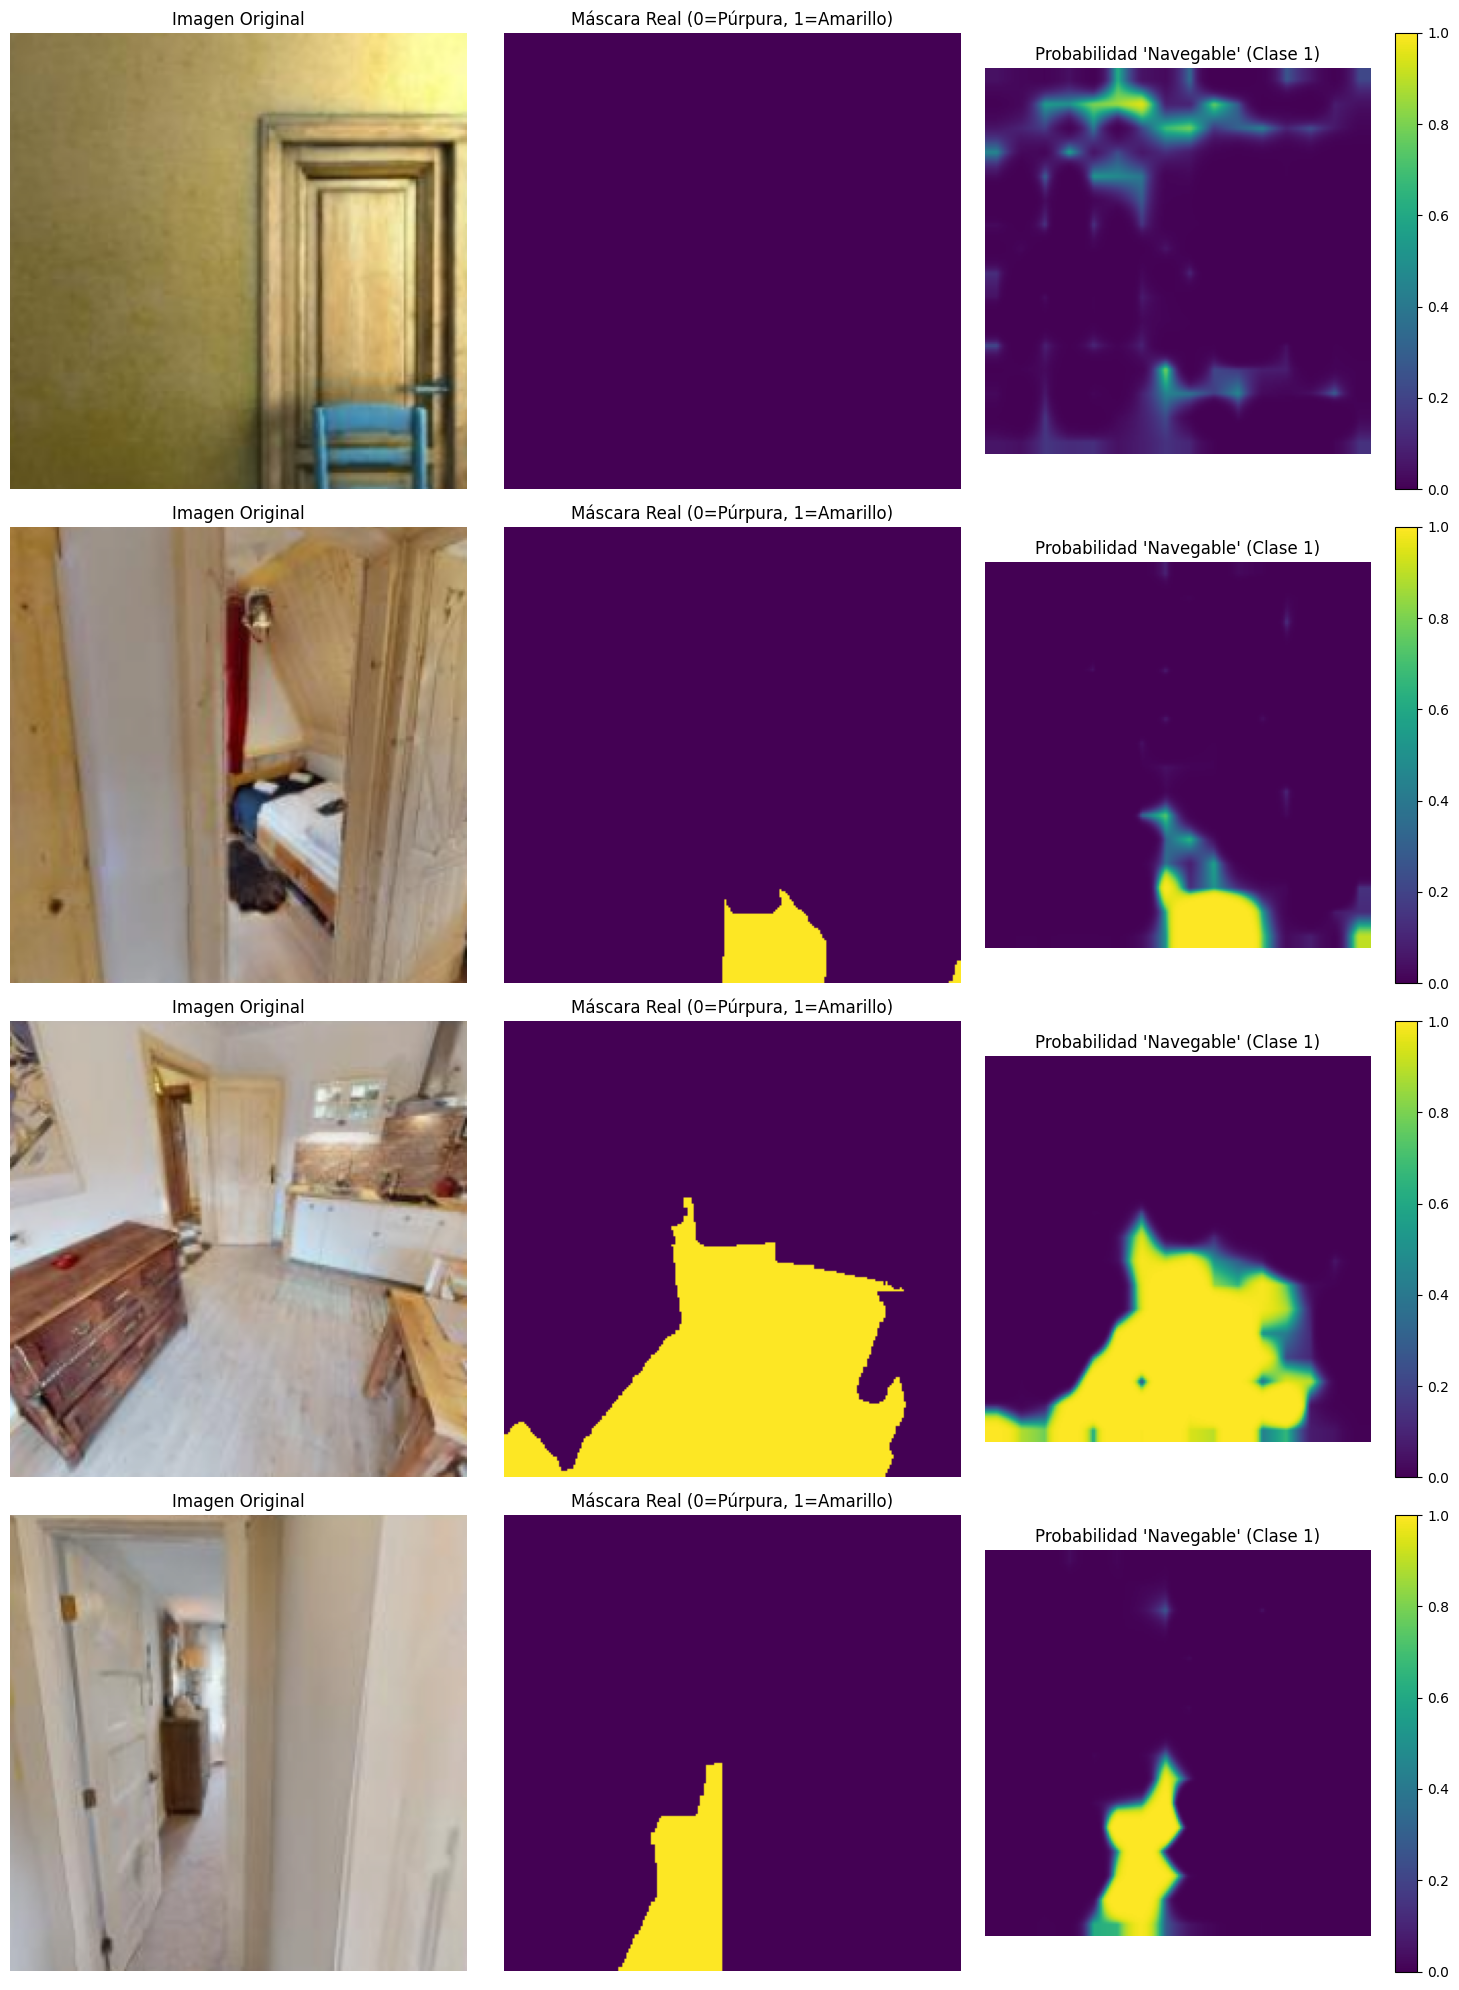

In [9]:
# ===================================================================
# PARTE 5.2: CARGAR PESOS Y VISUALIZAR PREDICCIONES (MODIFICADO)
# ===================================================================

# --- 1. Cargar los pesos del mejor modelo ---
try:
    seg_head.load_state_dict(torch.load("best_seg_head_weights.pth"))
    seg_head.to(device)
    print("Pesos del mejor modelo ('best_seg_head_weights.pth') cargados.")
except Exception as e:
    print(f"Error al cargar los pesos: {e}")
    print("Asegúrate de que 'seg_head' esté definido y el archivo .pth exista.")

dinov2_model.eval()
seg_head.eval()

# (La función 'unnormalize' de antes sigue siendo la misma)
def unnormalize(tensor, mean, std):
    tensor = tensor.clone() 
    if tensor.device != torch.device('cpu'):
        tensor = tensor.cpu()
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    tensor = tensor.permute(1, 2, 0)
    tensor = torch.clamp(tensor, 0, 1)
    return tensor.numpy()

# --- 3. Bucle de Inferencia y Visualización ---
if test_dataloader:
    print("Generando predicciones del primer lote de prueba...")
    
    with torch.no_grad():
        try:
            images, masks_true = next(iter(test_dataloader))
        except StopIteration:
            print("El DataLoader de prueba está vacío.")
            images, masks_true = None, None

        if images is not None:
            images = images.to(device)
            masks_true = masks_true.to(device) 

            patch_features = get_patch_features(images)
            logits = seg_head(patch_features) # Forma: [B, 2, 224, 224]

            # Aplicamos Softmax para convertir las puntuaciones en probabilidades (0.0 a 1.0)
            probabilities = F.softmax(logits, dim=1) 
            
            # Obtenemos el mapa de probabilidad solo para la clase '1' (navegable)
            prob_map_navigable = probabilities[:, 1, :, :].cpu().numpy()

            images_cpu = images.cpu()
            masks_true_cpu = masks_true.cpu().numpy()
            
            num_images_to_show = len(images_cpu)
            fig, axes = plt.subplots(num_images_to_show, 3, figsize=(15, num_images_to_show * 5))
            
            if num_images_to_show == 1:
                axes = np.array([axes])

            for i in range(num_images_to_show):
                img_display = unnormalize(images_cpu[i], DINO_MEANS, DINO_STDS)

                # Columna 1: Imagen Original
                axes[i, 0].imshow(img_display)
                axes[i, 0].set_title("Imagen Original")
                axes[i, 0].axis('off')

                # --- MODIFICACIÓN DE PLOTEO (MÁSCARA REAL) ---
                # Usamos un mapa de color ('viridis') para ver 0 y 1 en colores distintos
                axes[i, 1].imshow(masks_true_cpu[i], cmap='viridis', vmin=0, vmax=1)
                axes[i, 1].set_title("Máscara Real (0=Púrpura, 1=Amarillo)")
                axes[i, 1].axis('off')
                # ----------------------------------------------

                # Columna 3: Probabilidad Predicha
                im = axes[i, 2].imshow(prob_map_navigable[i], cmap='viridis', vmin=0, vmax=1)
                axes[i, 2].set_title("Probabilidad 'Navegable' (Clase 1)")
                axes[i, 2].axis('off')
                fig.colorbar(im, ax=axes[i, 2]) # Añadir barra de color

            plt.tight_layout()
            plt.show()
else:
    print("No se pudo ejecutar la prueba. Asegúrate de que 'test_dataloader' se haya creado correctamente.")

In [15]:
# Añade esta importación junto con las demás (plt, torch, np, etc.)
#!pip install scikit-image


from skimage.morphology import skeletonize, thin

Generando predicciones del primer lote de prueba...


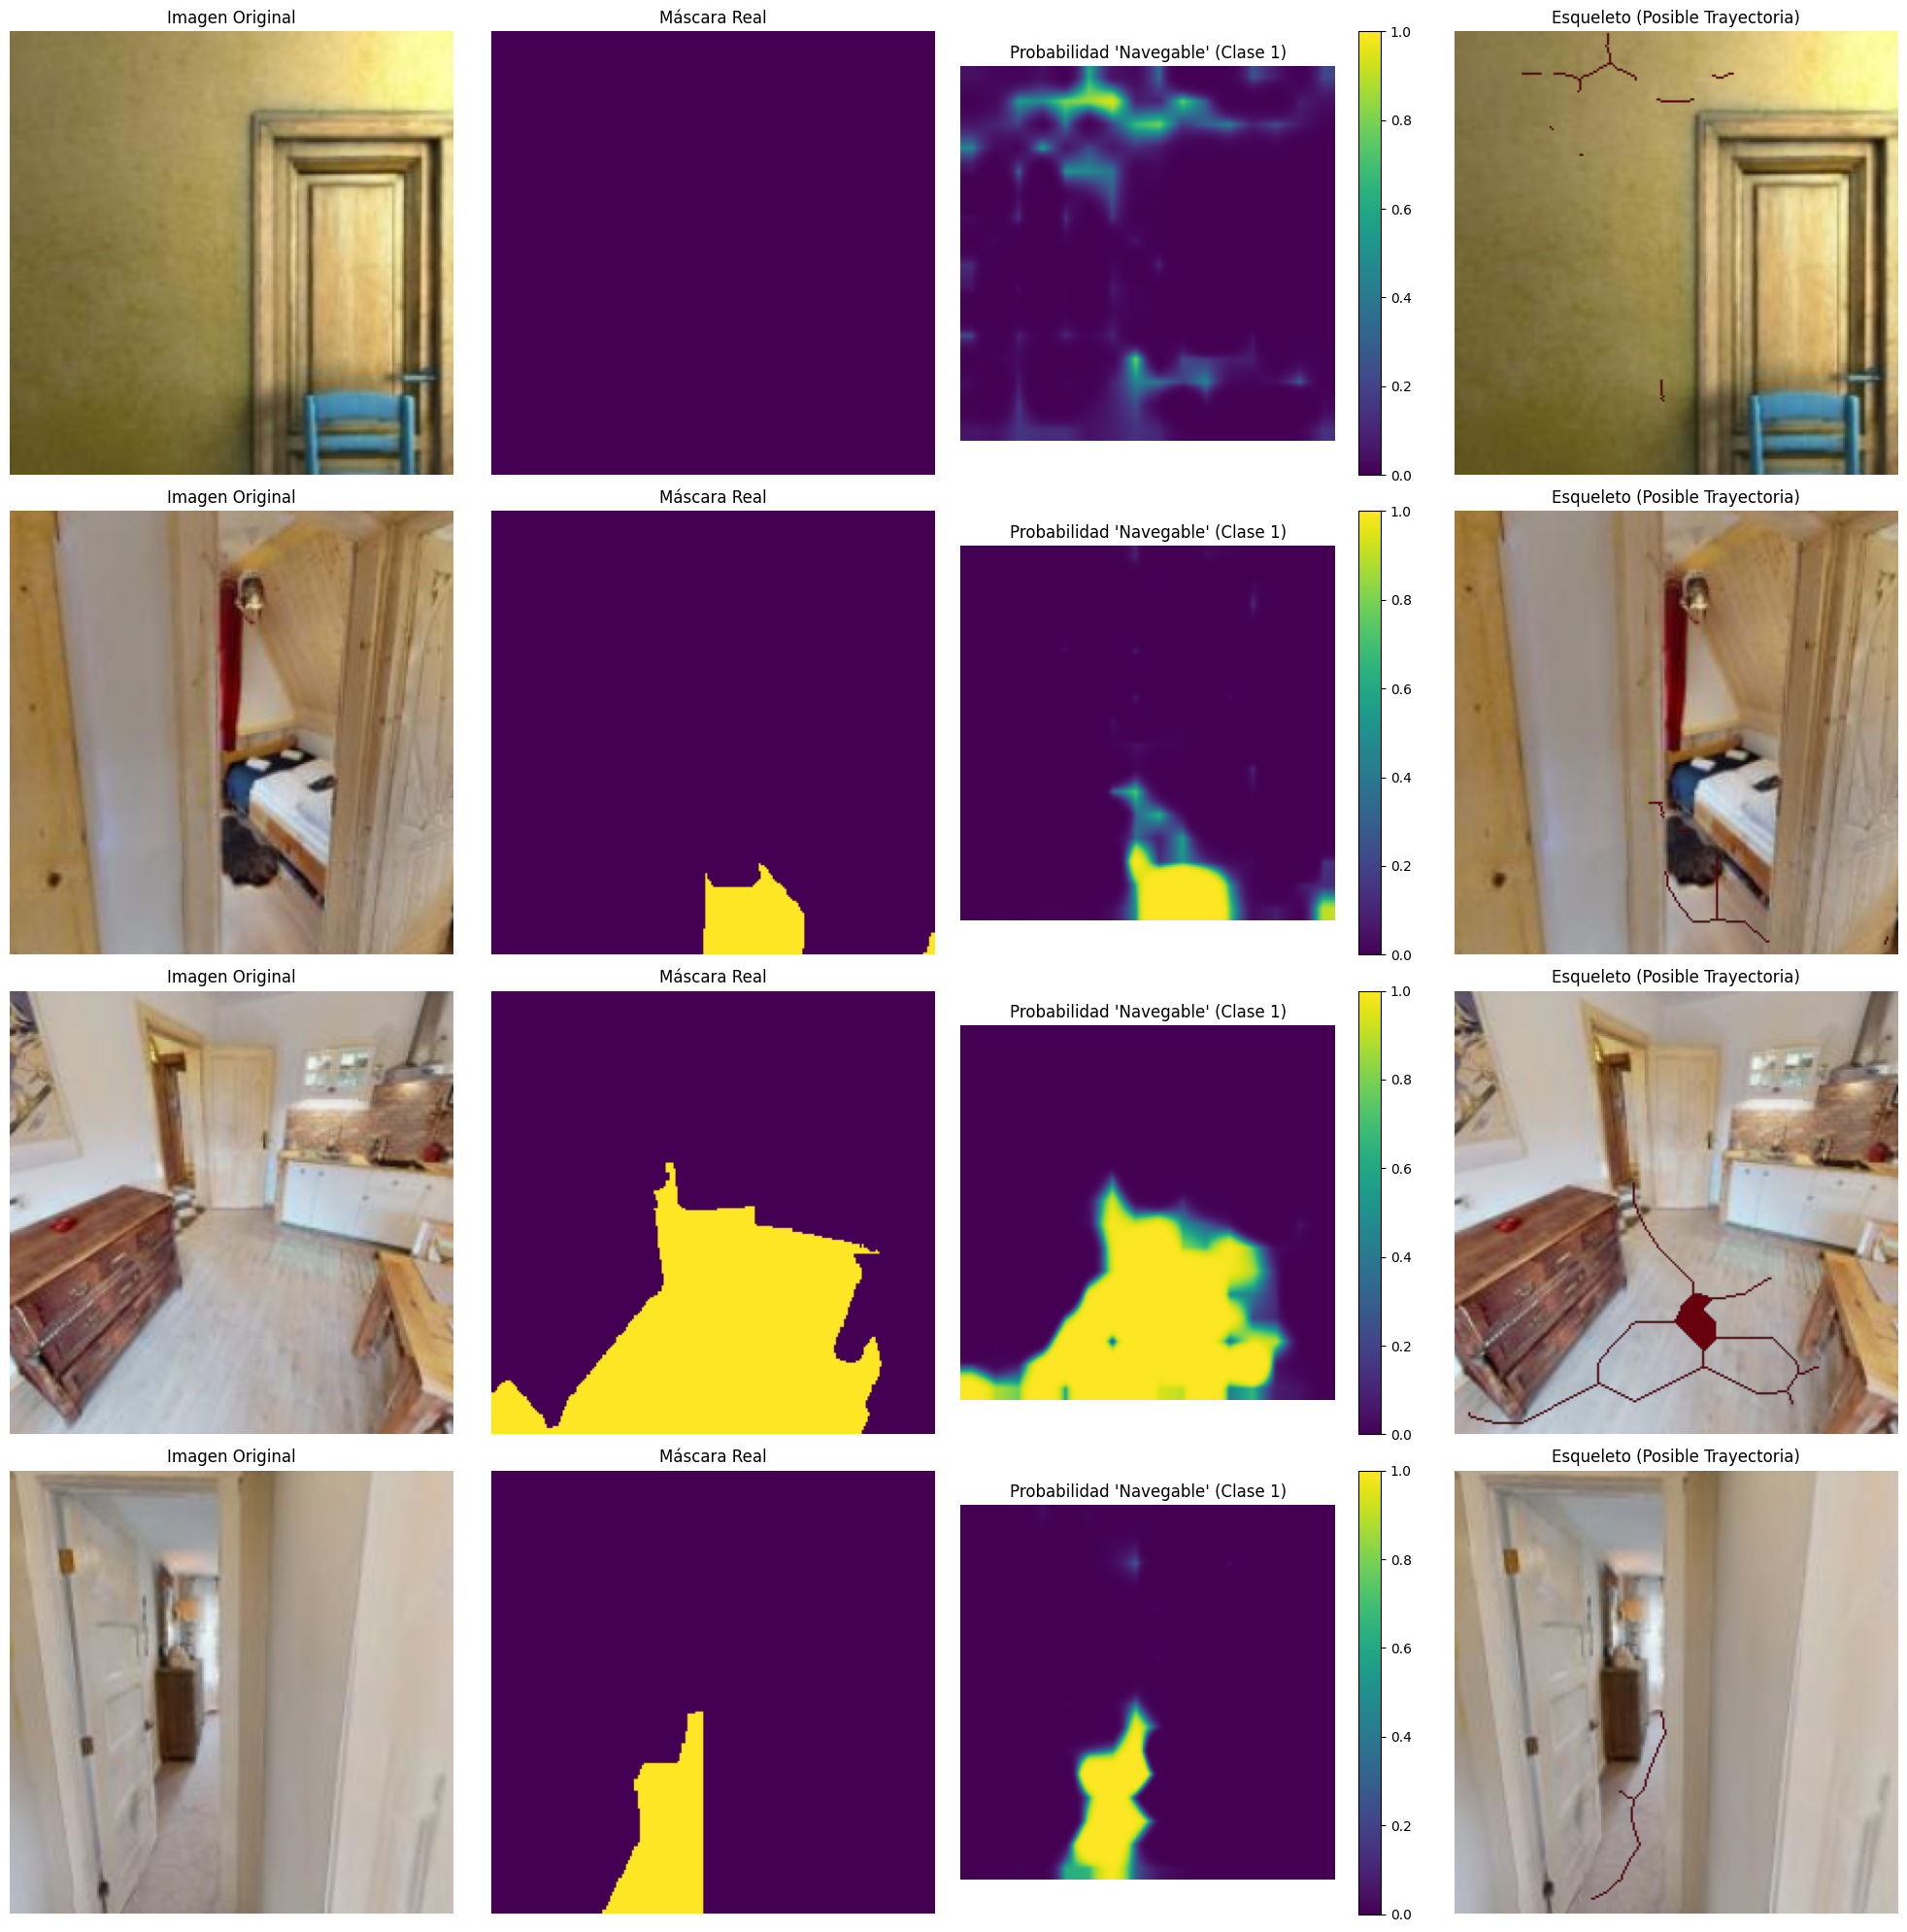

In [19]:
# ===================================================================
# PARTE 5.2: CARGAR PESOS Y VISUALIZAR PREDICCIONES (MODIFICADO)
# ===================================================================

# ... (tu código de carga de pesos y definición de 'unnormalize' va aquí) ...

# --- 3. Bucle de Inferencia y Visualización (MODIFICADO CON ESQUELETO) ---
if test_dataloader:
    print("Generando predicciones del primer lote de prueba...")
    
    with torch.no_grad():
        try:
            images, masks_true = next(iter(test_dataloader))
        except StopIteration:
            print("El DataLoader de prueba está vacío.")
            images, masks_true = None, None

        if images is not None:
            images = images.to(device)
            masks_true = masks_true.to(device) 

            patch_features = get_patch_features(images)
            logits = seg_head(patch_features) 
            probabilities = F.softmax(logits, dim=1) 
            
            # Mapa de probabilidad para la clase '1' (navegable)
            prob_map_navigable = probabilities[:, 1, :, :].cpu().numpy()

            images_cpu = images.cpu()
            masks_true_cpu = masks_true.cpu().numpy()
            
            num_images_to_show = len(images_cpu)
            
            # --- MODIFICACIÓN: 4 columnas en lugar de 3 ---
            fig, axes = plt.subplots(num_images_to_show, 4, figsize=(20, num_images_to_show * 5))
            
            if num_images_to_show == 1:
                axes = np.array([axes])

            for i in range(num_images_to_show):
                img_display = unnormalize(images_cpu[i], DINO_MEANS, DINO_STDS)
                prob_map = prob_map_navigable[i]

                # Columna 1: Imagen Original
                axes[i, 0].imshow(img_display)
                axes[i, 0].set_title("Imagen Original")
                axes[i, 0].axis('off')

                # Columna 2: Máscara Real
                axes[i, 1].imshow(masks_true_cpu[i], cmap='viridis', vmin=0, vmax=1)
                axes[i, 1].set_title("Máscara Real")
                axes[i, 1].axis('off')

                # Columna 3: Probabilidad Predicha
                im = axes[i, 2].imshow(prob_map, cmap='viridis', vmin=0, vmax=1)
                axes[i, 2].set_title("Probabilidad 'Navegable' (Clase 1)")
                axes[i, 2].axis('off')
                fig.colorbar(im, ax=axes[i, 2])

                # --- NUEVA COLUMNA 4: BINARIZACIÓN Y ESQUELETIZACIÓN ---
                
                # 1. Binarizar el mapa de probabilidad
                # Puedes (y debes) ajustar este umbral según tus resultados
                threshold = 0.5 
                binary_mask = prob_map > threshold
                
                # 2. Aplicar skeletization
                # skeletonize funciona mejor sobre un array booleano
                #skeleton = skeletonize(binary_mask)
                skeleton = thin(binary_mask, max_num_iter=40)
                
                # 3. Mostrar el esqueleto superpuesto
                # Es más útil verlo sobre la imagen original
                axes[i, 3].imshow(img_display)
                
                # Creamos una máscara para que solo se muestre el esqueleto (en rojo)
                skeleton_overlay = np.ma.masked_where(skeleton == 0, skeleton)
                #axes[i, 3].imshow(skeleton_overlay, cmap='Reds', alpha=1.0) # 'Reds' para alta visibilidad
                axes[i, 3].imshow(skeleton_overlay, cmap='Reds', alpha=1.0, vmin=0, vmax=1)
                axes[i, 3].set_title("Esqueleto (Posible Trayectoria)")
                axes[i, 3].axis('off')
                # ----------------------------------------------------

            plt.tight_layout()
            plt.show()
else:
    print("No se pudo ejecutar la prueba. Asegúrate de que 'test_dataloader' se haya creado correctamente.")